### Notebook for `leiden` clustering of 6mpi lymphoids of all conditions

#### Environment: SCCAF

- **Developed by**: Alexandra Cirnu
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 240320
- **Last modified**: 240327

#### Load required modules

In [41]:
import SCCAF
from SCCAF import SCCAF_assessment, plot_roc
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
import muon as mu
from muon import atac as ac
from muon import prot as pt

In [42]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

-----
anndata     0.10.6
scanpy      1.9.8
-----
PIL                 10.2.0
SCCAF               NA
asttokens           NA
attr                23.2.0
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
h5py                3.10.0
igraph              0.11.4
ipykernel           6.29.3
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.42.0
louvain             0.8.2
matplotlib          3.8.3
matplotlib_inline   0.1.6
mpl_toolkits        NA
mudata              0.2.3
muon                0.1.6
natsort             8.4.0
numba               0.59.1
numexpr             2.9.0
numpy               1.26.4
packaging           24.0
pandas              2.2.1
parso               0.8.3
patsy               0.5.6
pickleshare         0.7.5
pkg_resources    

In [43]:
warnings.simplefilter(action = 'ignore')
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

In [44]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

In [45]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

#### Load data set

In [46]:
input = '/home/acirnu/data/ACM_cardiac_leuco/4_Seed_labeling_with_scANVI/ACM_lymphoids_scANVI_general_celltypes_from_HCA_lymphoids_muon_ac240414.raw.h5mu'
mdata = mu.read_h5mu(input)
mdata

MuData object with n_obs × n_vars = 10104 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	10104 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
    prot:	10104 x 99
      obs:	'library', 'batch'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

In [47]:
adata = mdata.mod["rna"]
adata

AnnData object with n_obs × n_vars = 10104 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

Make sure to use raw counts

In [48]:
X_is_raw(adata)

True

In [49]:
X_data = adata.X.copy()
X_data_sparse = csr_matrix(X_data)
X_data_df = pd.DataFrame.sparse.from_spmatrix(X_data_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", X_data_df.shape)
print(X_data_df)

Shape of counts DataFrame: (10104, 29378)
                       Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  Gm37587  \
AAACCCAAGATACAGT-1-A1     0       0        0        0    0      0        0   
AACCCAATCAGCTGAT-1-A1     0       0        0        0    0      0        0   
AACCTGAAGATAGCAT-1-A1     0       0        0        0    0      0        0   
AACGTCAAGCTACTGT-1-A1     0       0        0        0    0      0        0   
AACTTCTCAAGCGCTC-1-A1     0       0        0        0    0      0        0   
...                     ...     ...      ...      ...  ...    ...      ...   
TTTGATCAGTATGACA-1-B2     0       0        0        0    0      0        0   
TTTGGAGAGATTAGCA-1-B2     0       0        0        0    0      0        0   
TTTGGTTAGCACCTGC-1-B2     0       0        0        0    0      0        0   
TTTGTTGAGACCTCCG-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTAGTAAGT-1-B2     0       0        0        0    0      0        0   

                     

Save raw counts

In [50]:
adata_raw = adata.copy()

#### Define neighbors

In [51]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


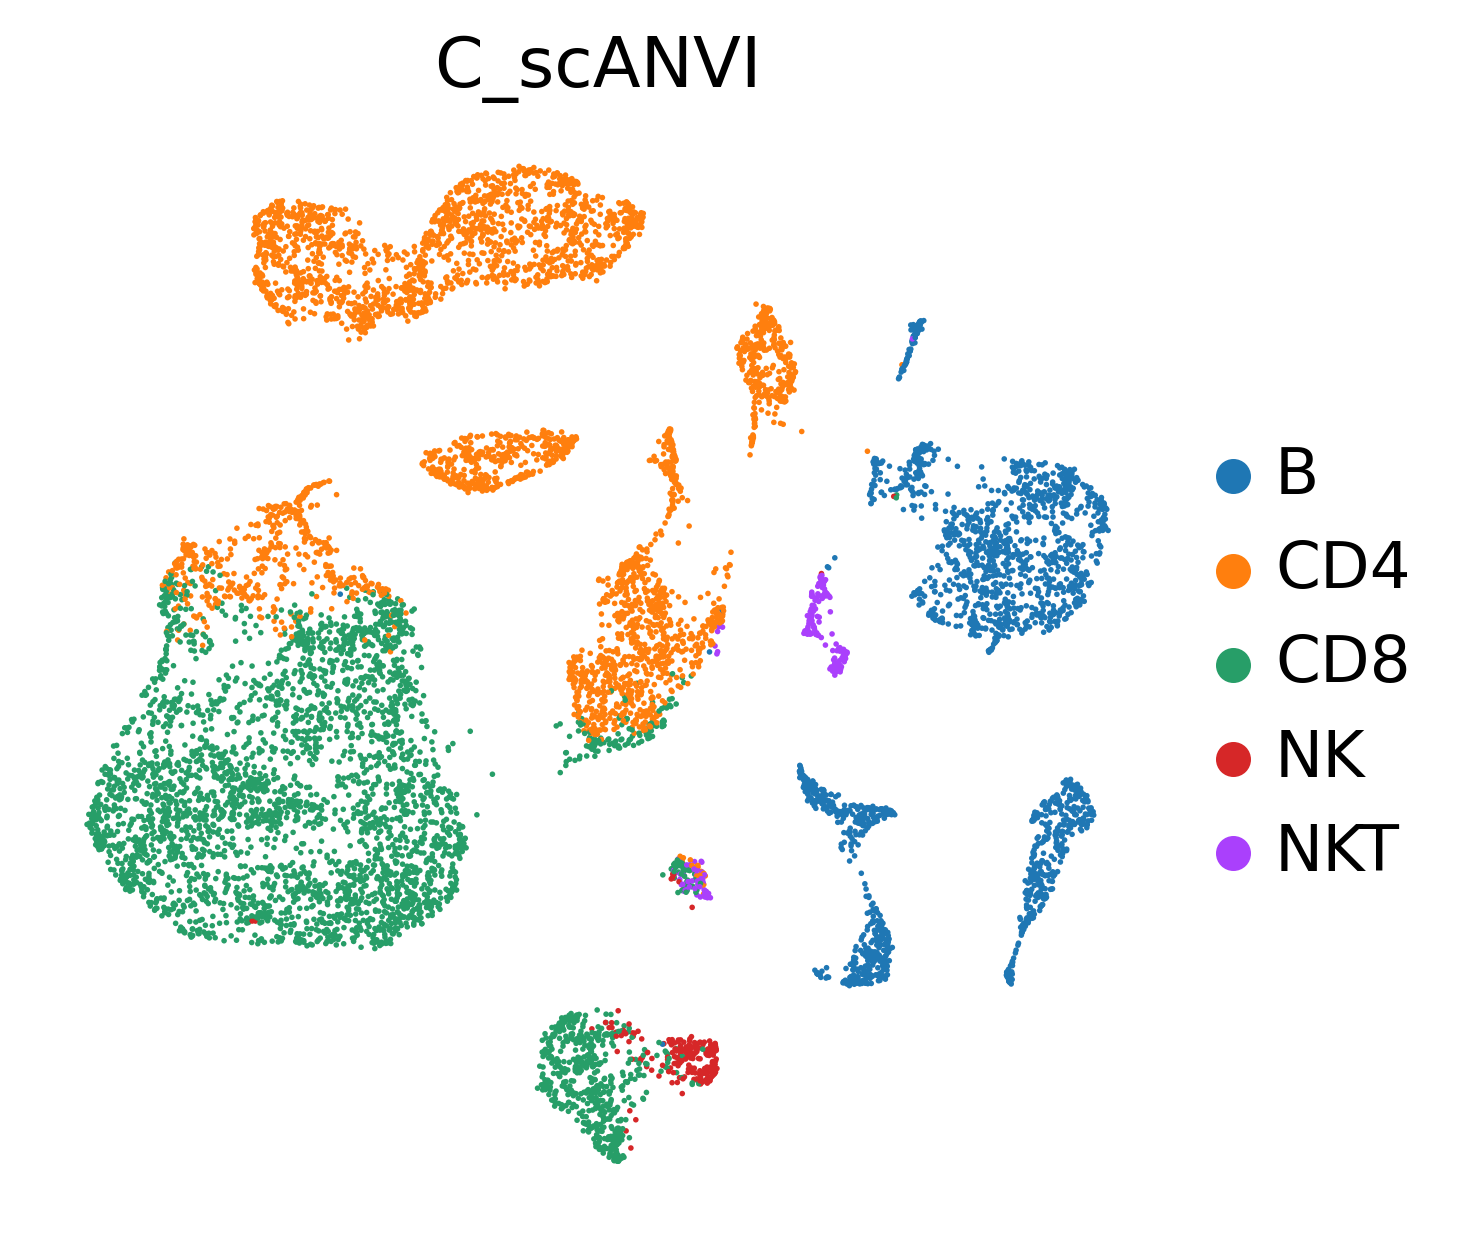

In [52]:
sc.pl.umap(adata, color=['C_scANVI'], size = 5, frameon = False)

In [53]:
adata

AnnData object with n_obs × n_vars = 10104 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'
    uns: 'neighbors', 'C_scANVI_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

#### Normalize and log transform data (modify adata.X), raw counts are still stored in adata.raw

In [54]:
sc.pp.normalize_total(adata, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Cst3', 'Fabp4', 'Actb', 'Igkc', 'Hbb-bs', 'Hba-a1', 'Ccl5', 'Ccl4', 'Igha', 'Ighg2c', 'Ighm', 'Iglc1', 'Iglc2', 'Retnla', 'Gm26917', 'Gm42418', 'Cd74', 'Malat1', 'Tmsb4x']
    finished (0:00:00)


In [55]:
X_data = adata.X.copy()
X_data_sparse = csr_matrix(X_data)
X_data_df = pd.DataFrame.sparse.from_spmatrix(X_data_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", X_data_df.shape)
print(X_data_df)

Shape of counts DataFrame: (10104, 29378)
                       Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  Gm37587  \
AAACCCAAGATACAGT-1-A1     0       0        0        0    0      0        0   
AACCCAATCAGCTGAT-1-A1     0       0        0        0    0      0        0   
AACCTGAAGATAGCAT-1-A1     0       0        0        0    0      0        0   
AACGTCAAGCTACTGT-1-A1     0       0        0        0    0      0        0   
AACTTCTCAAGCGCTC-1-A1     0       0        0        0    0      0        0   
...                     ...     ...      ...      ...  ...    ...      ...   
TTTGATCAGTATGACA-1-B2     0       0        0        0    0      0        0   
TTTGGAGAGATTAGCA-1-B2     0       0        0        0    0      0        0   
TTTGGTTAGCACCTGC-1-B2     0       0        0        0    0      0        0   
TTTGTTGAGACCTCCG-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTAGTAAGT-1-B2     0       0        0        0    0      0        0   

                     

#### Perform leiden clustering with resolution 0.1 and assess with SCCAF

In [16]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
Mean CV accuracy: 0.9728
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9782


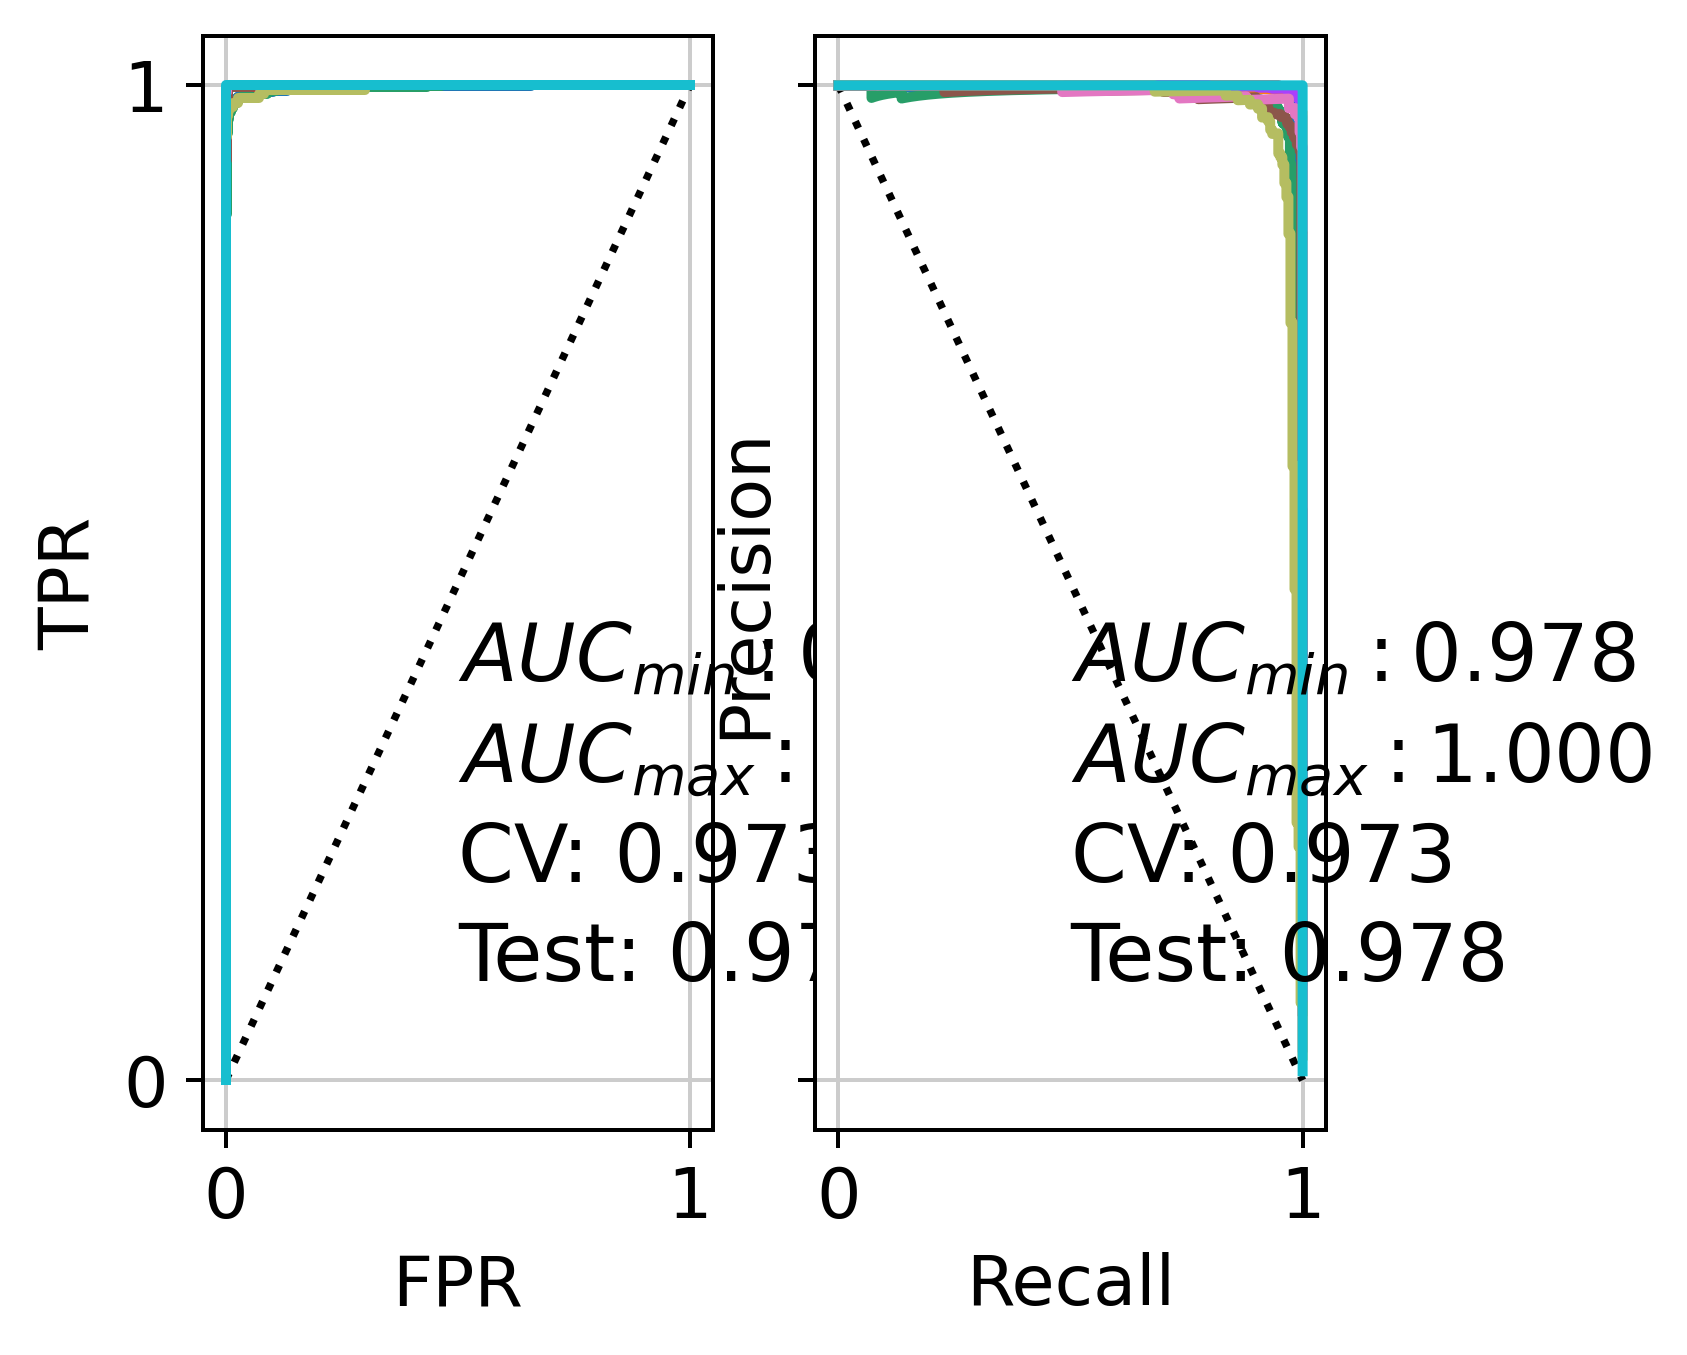

In [17]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.1, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.2 and assess with SCCAF

In [18]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
Mean CV accuracy: 0.9828
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9768


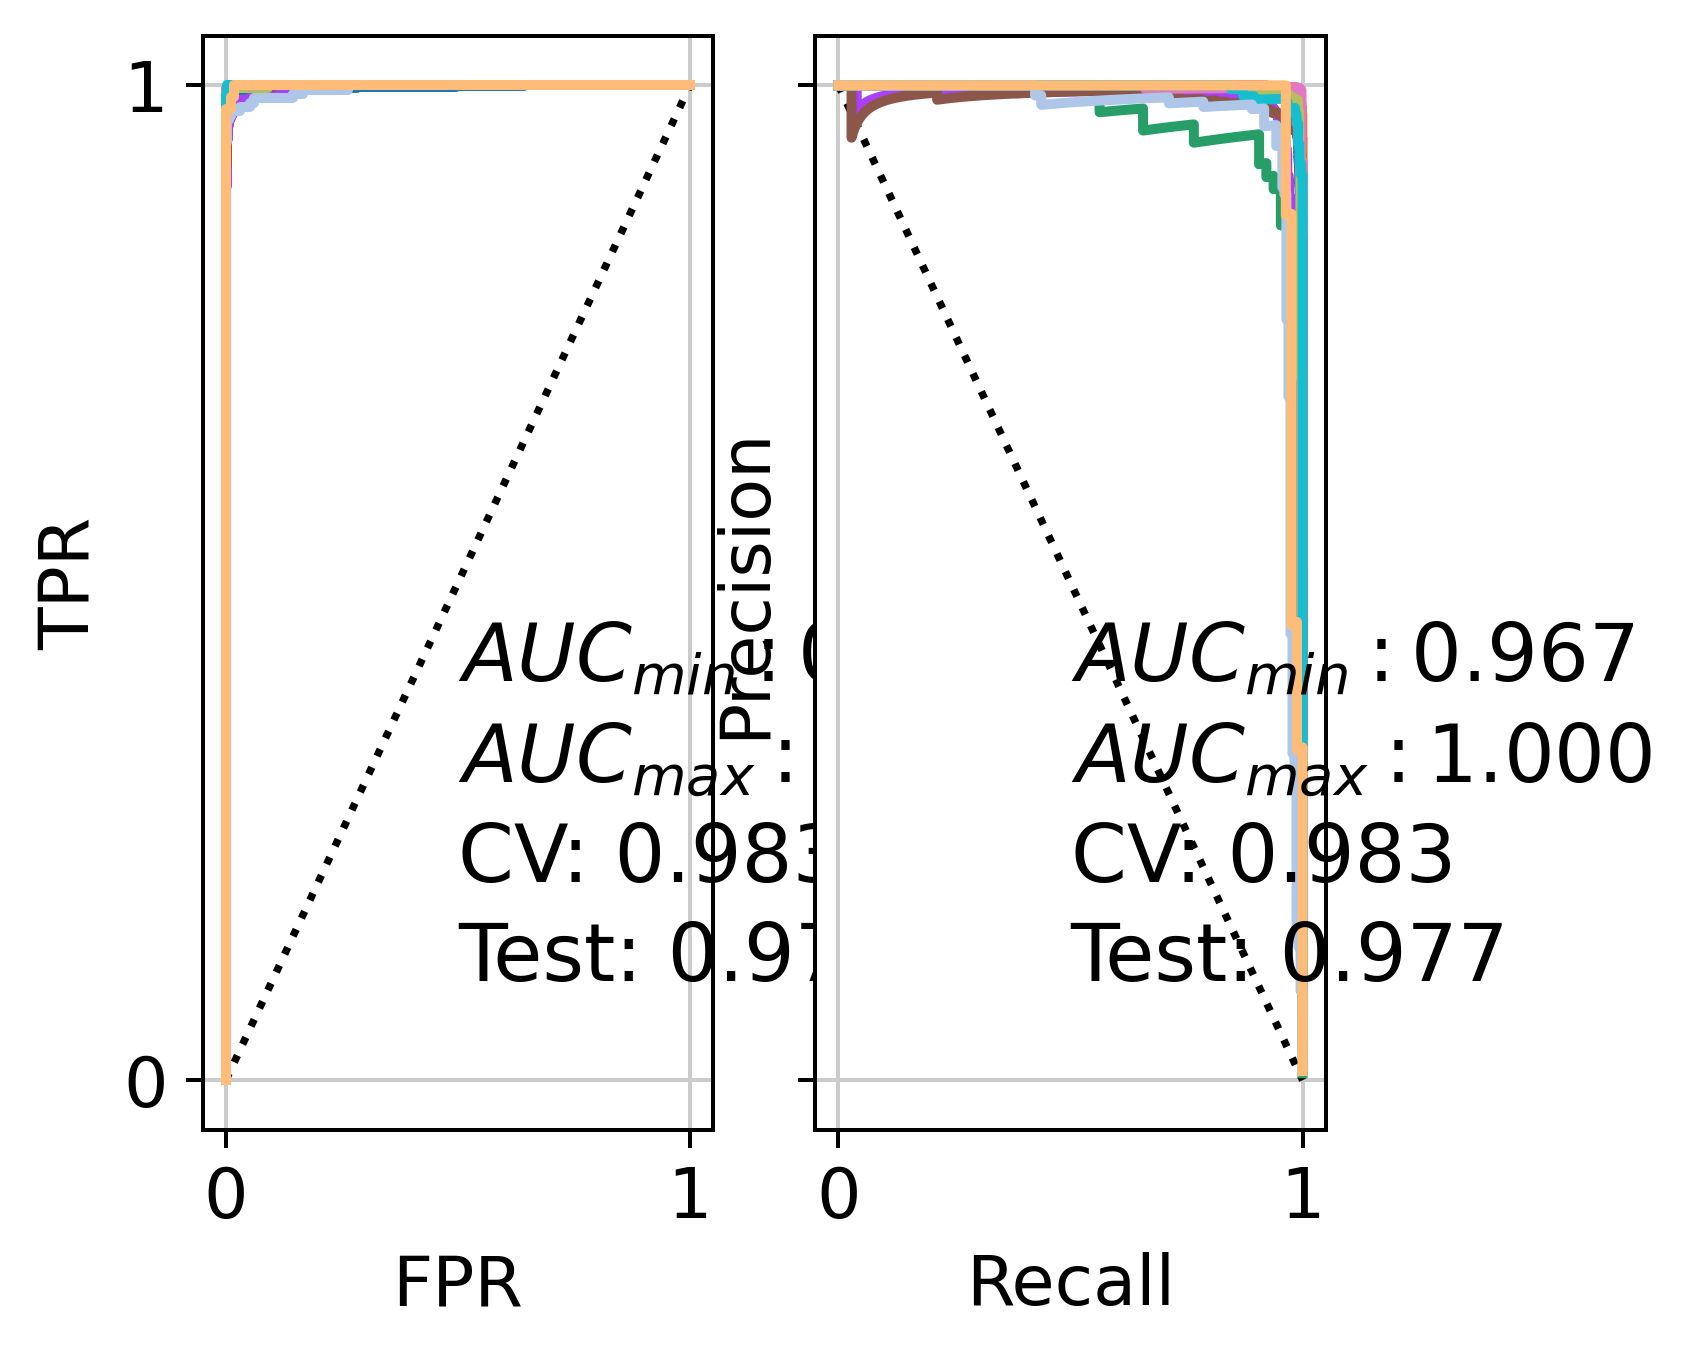

In [19]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.2, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.3 and assess with SCCAF

In [20]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
Mean CV accuracy: 0.9516
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9488


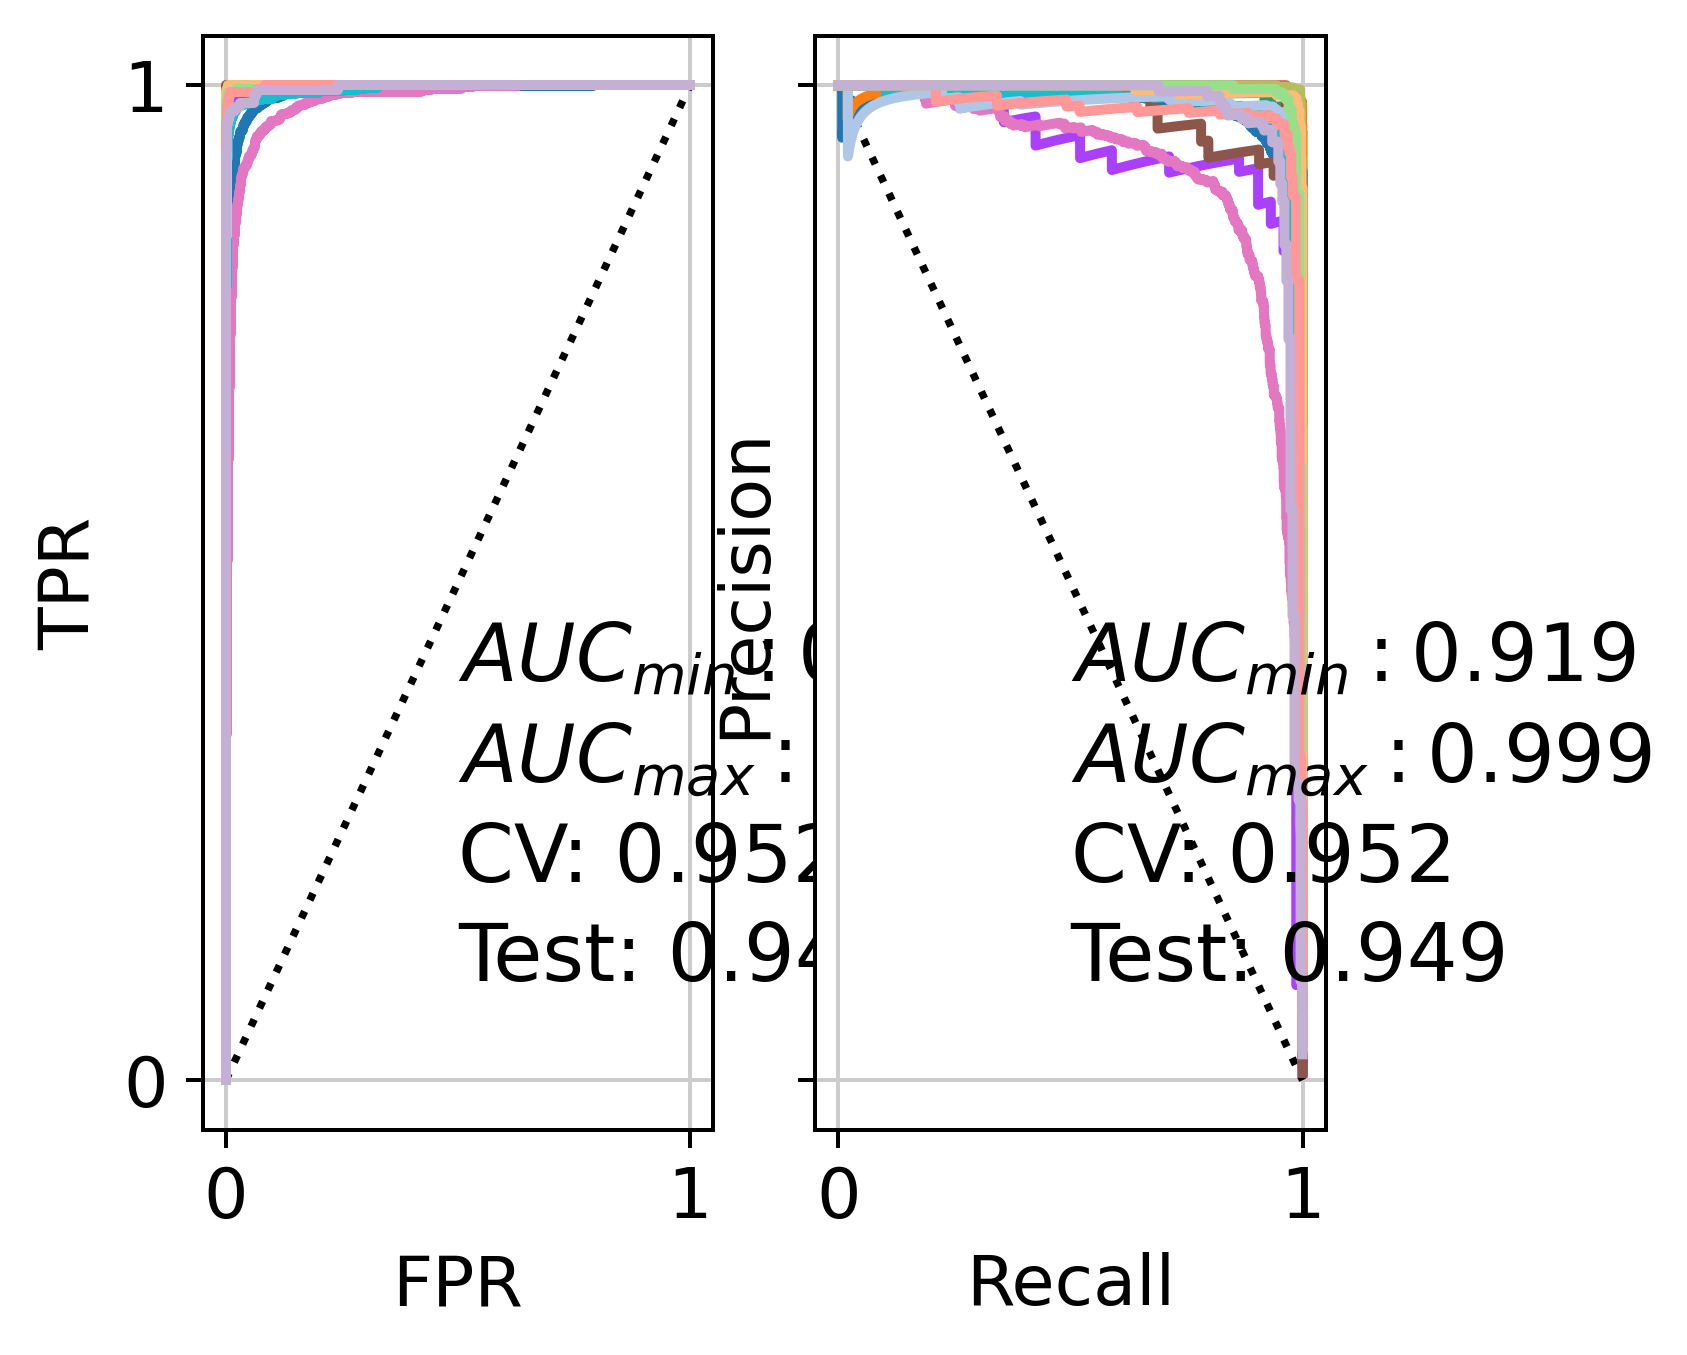

In [21]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.3, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.4 and assess with SCCAF

In [22]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)
Mean CV accuracy: 0.9442
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9268


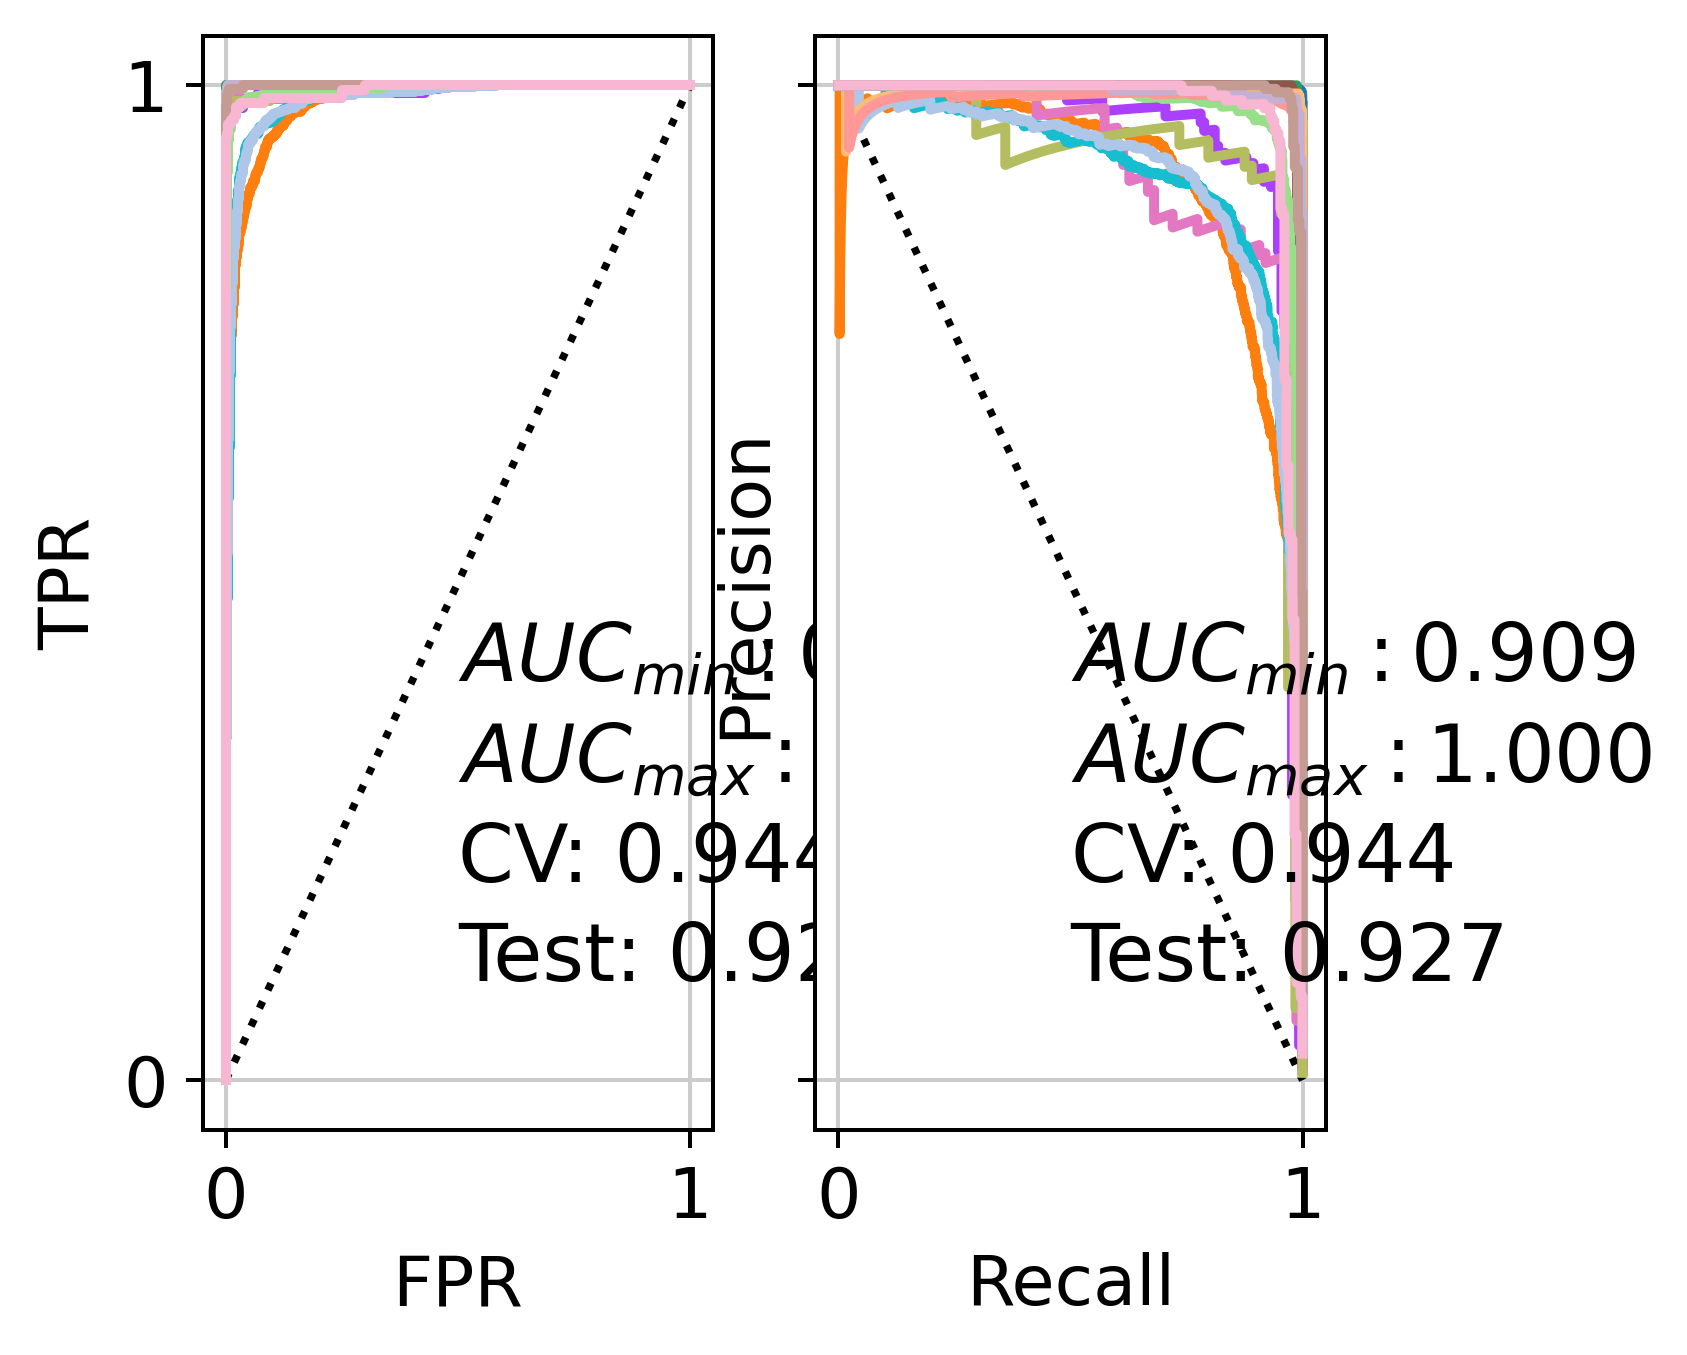

In [23]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.4, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.5 and assess with SCCAF

In [24]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
Mean CV accuracy: 0.9297
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9287


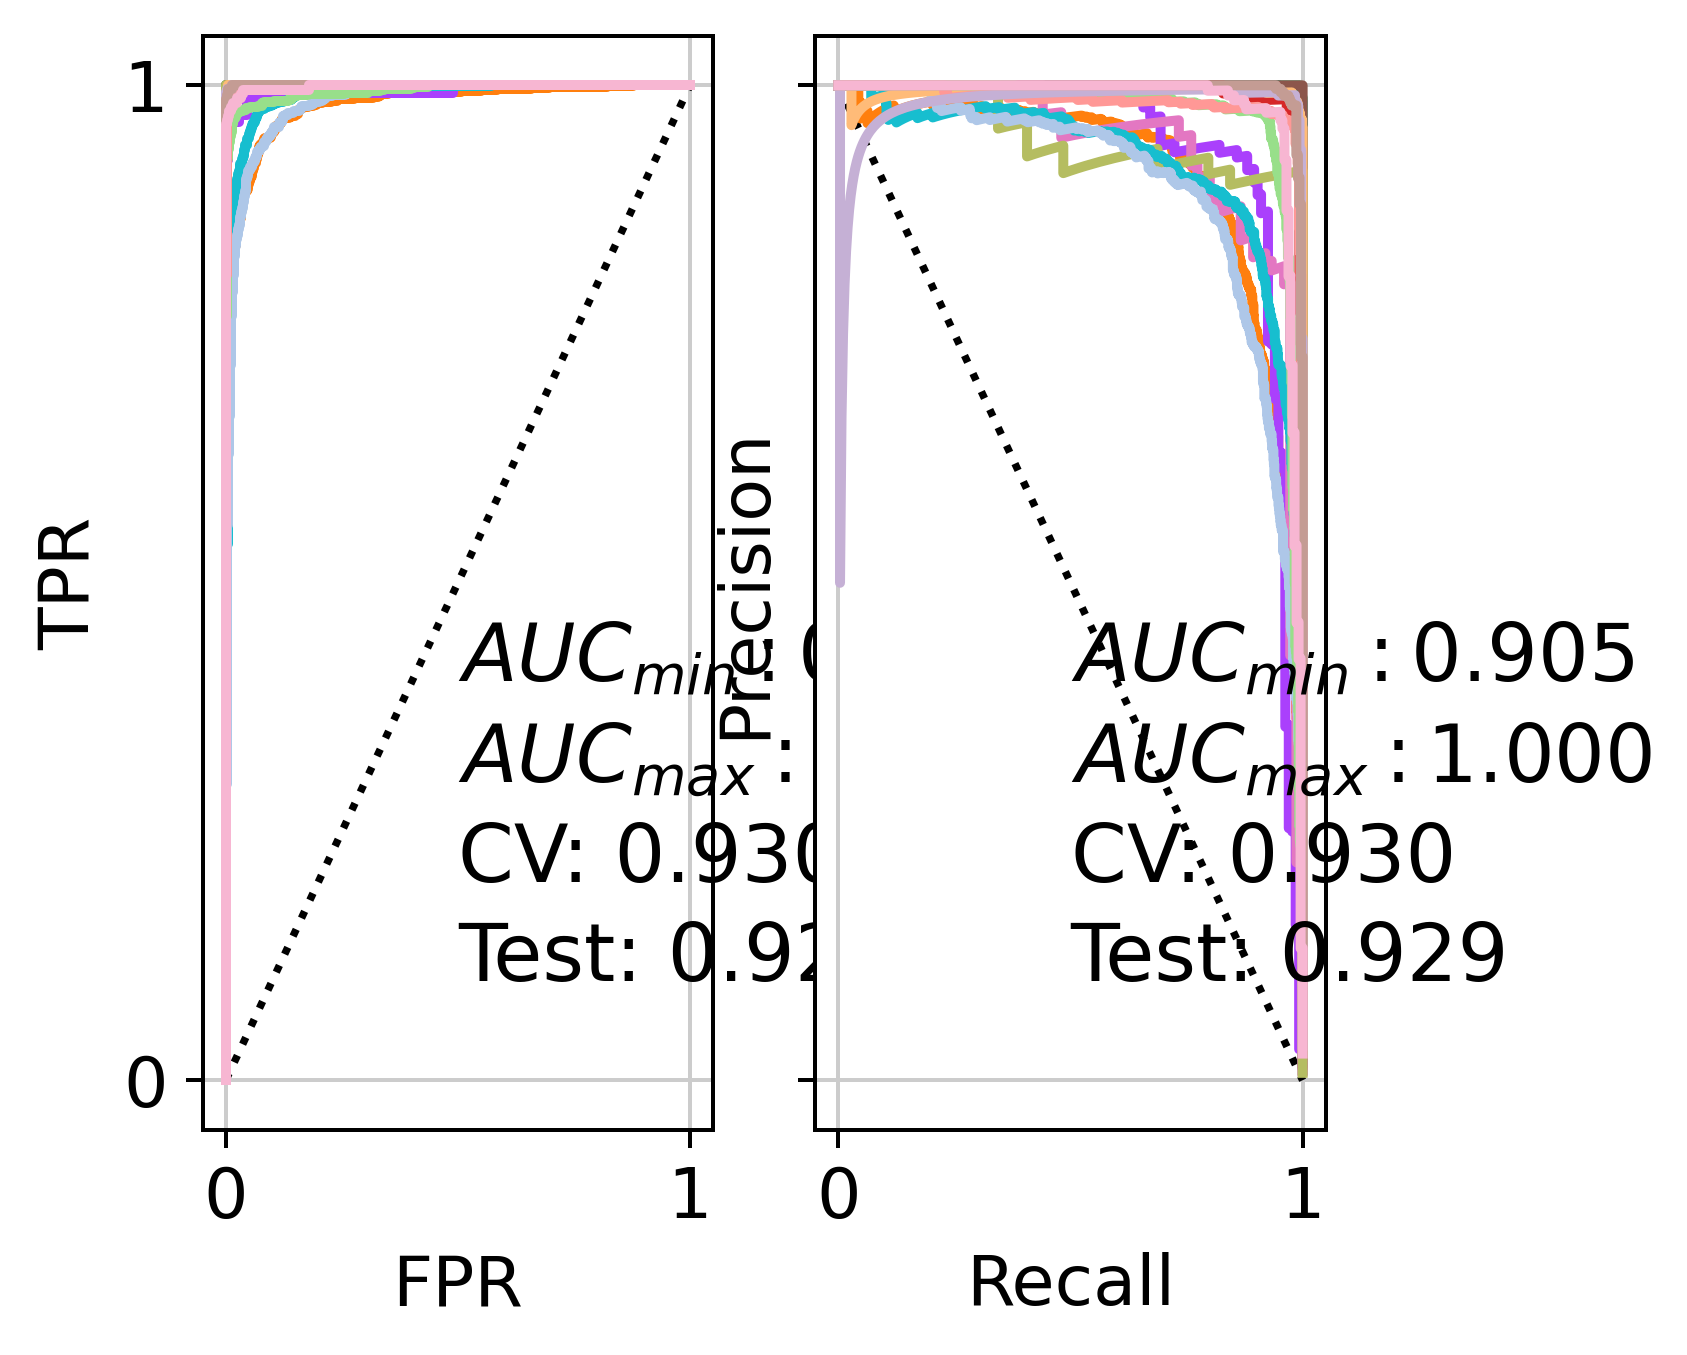

In [25]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.5, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.6 and assess with SCCAF

In [26]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
Mean CV accuracy: 0.9181
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8918


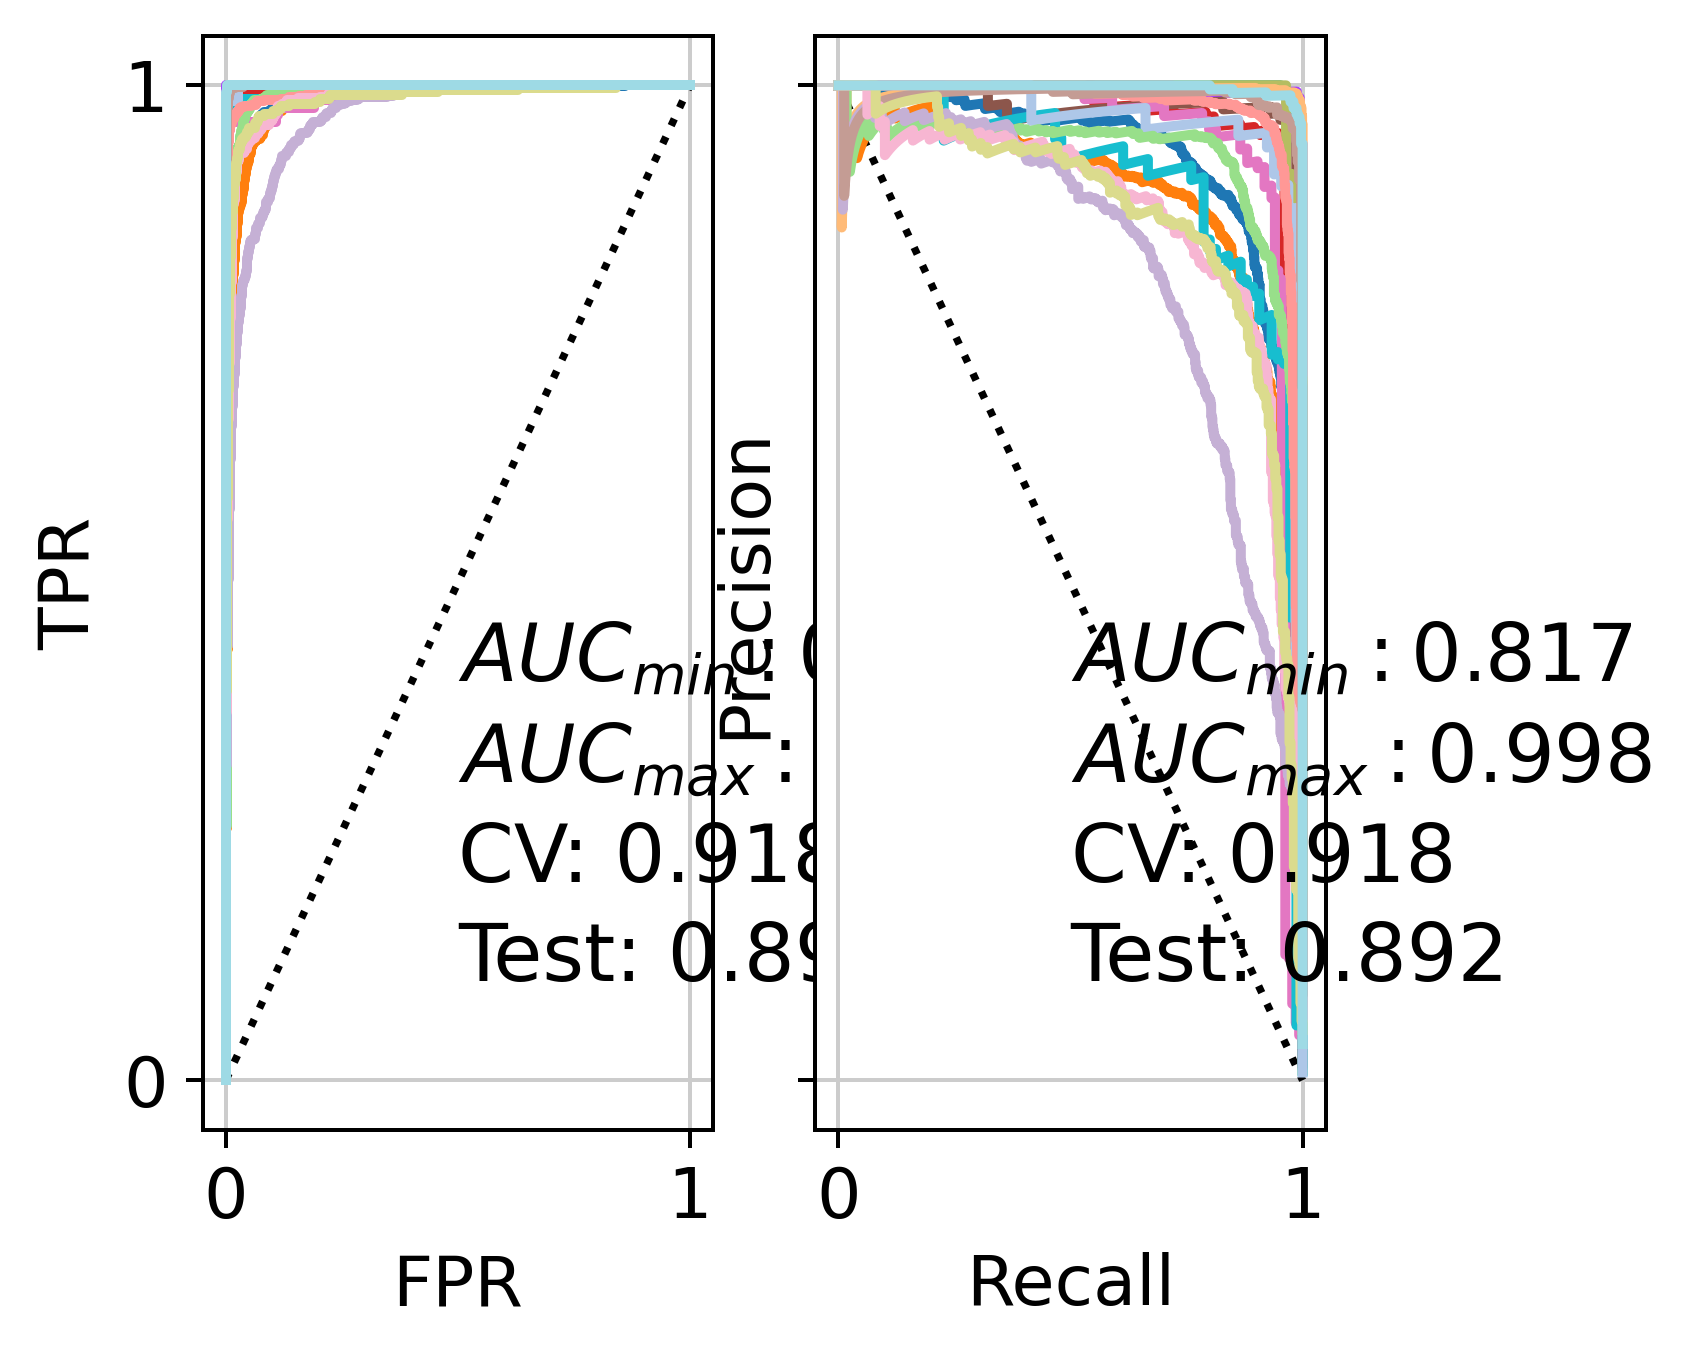

In [27]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.6, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.7 and assess with SCCAF

In [28]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
Mean CV accuracy: 0.9245
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9022


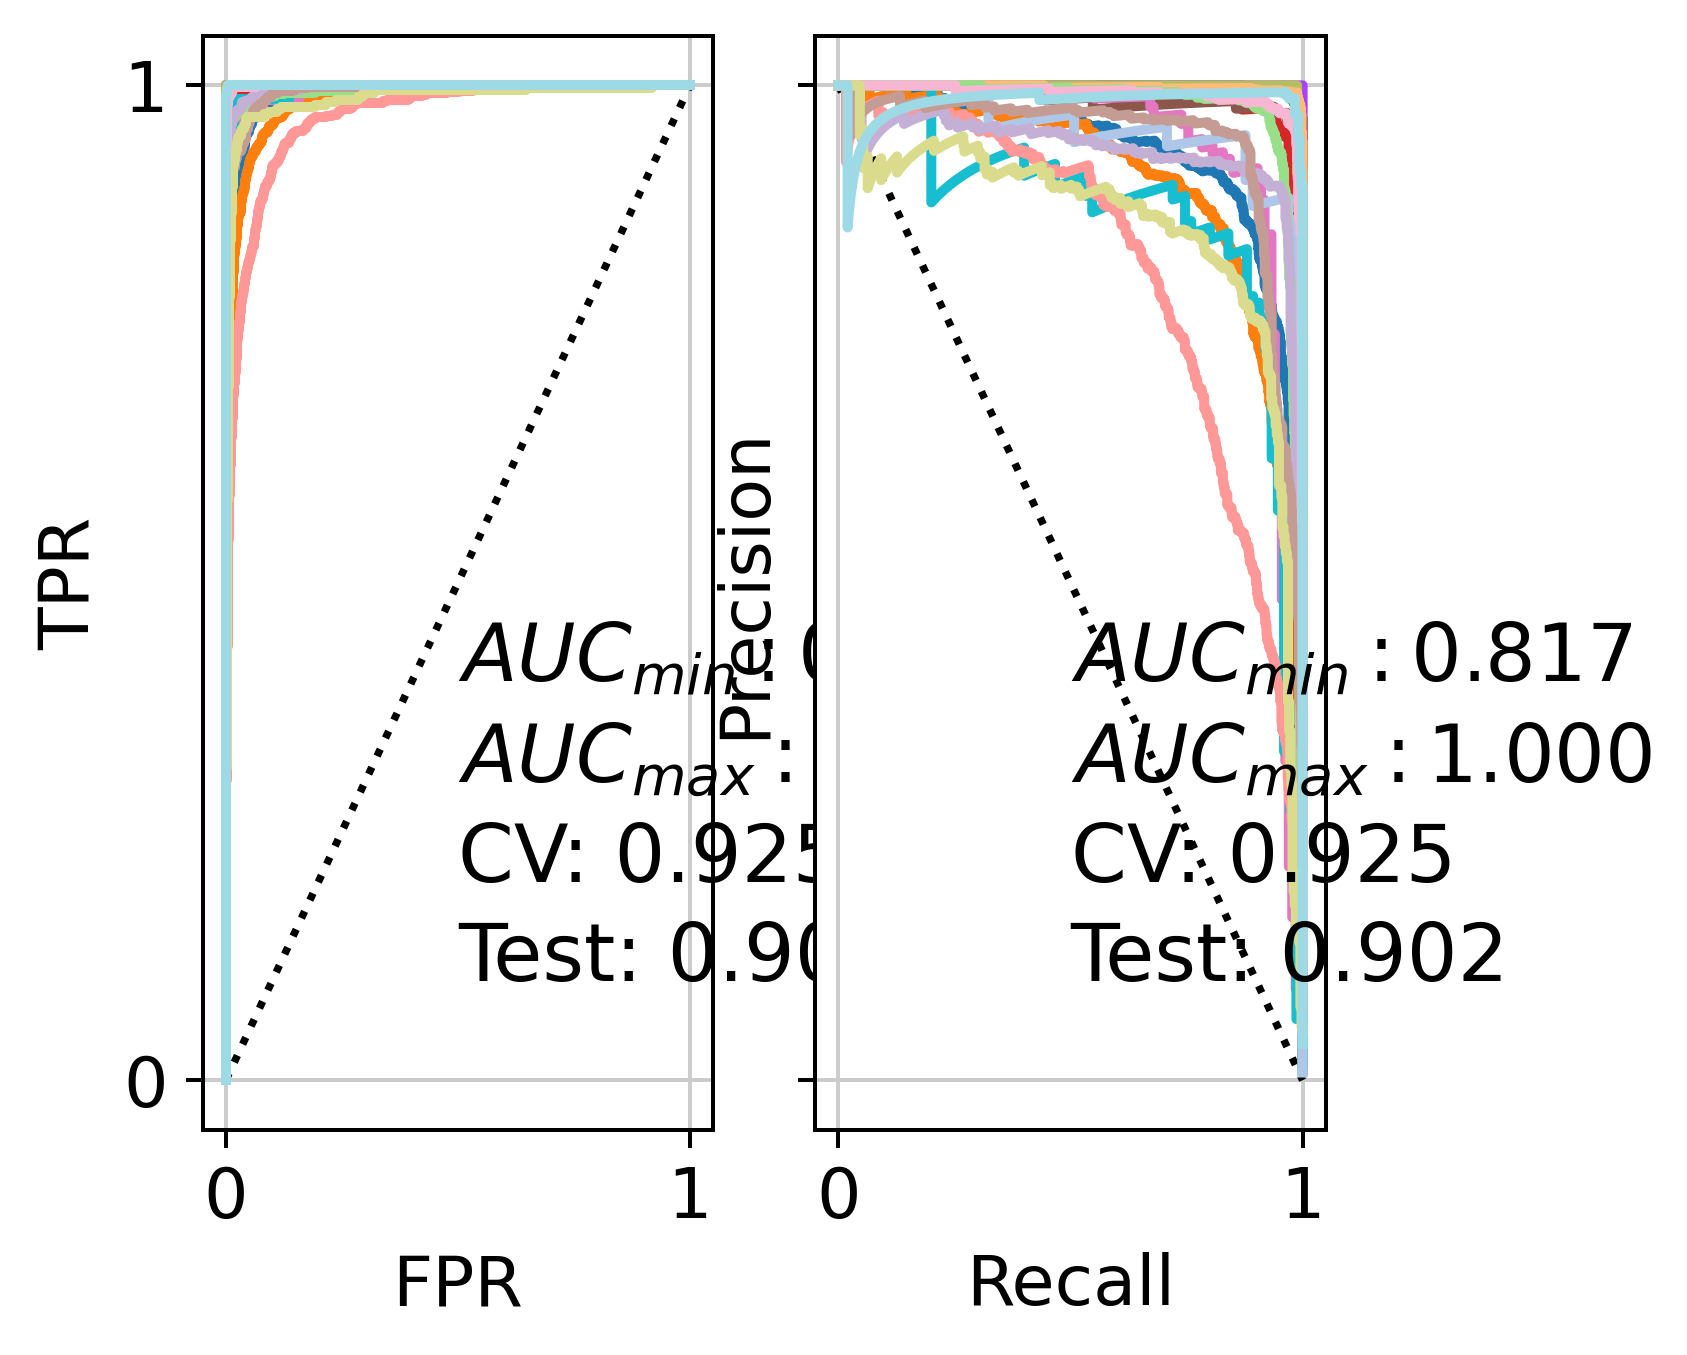

In [29]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.7, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.8 and assess with SCCAF

In [30]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
Mean CV accuracy: 0.8909
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8740


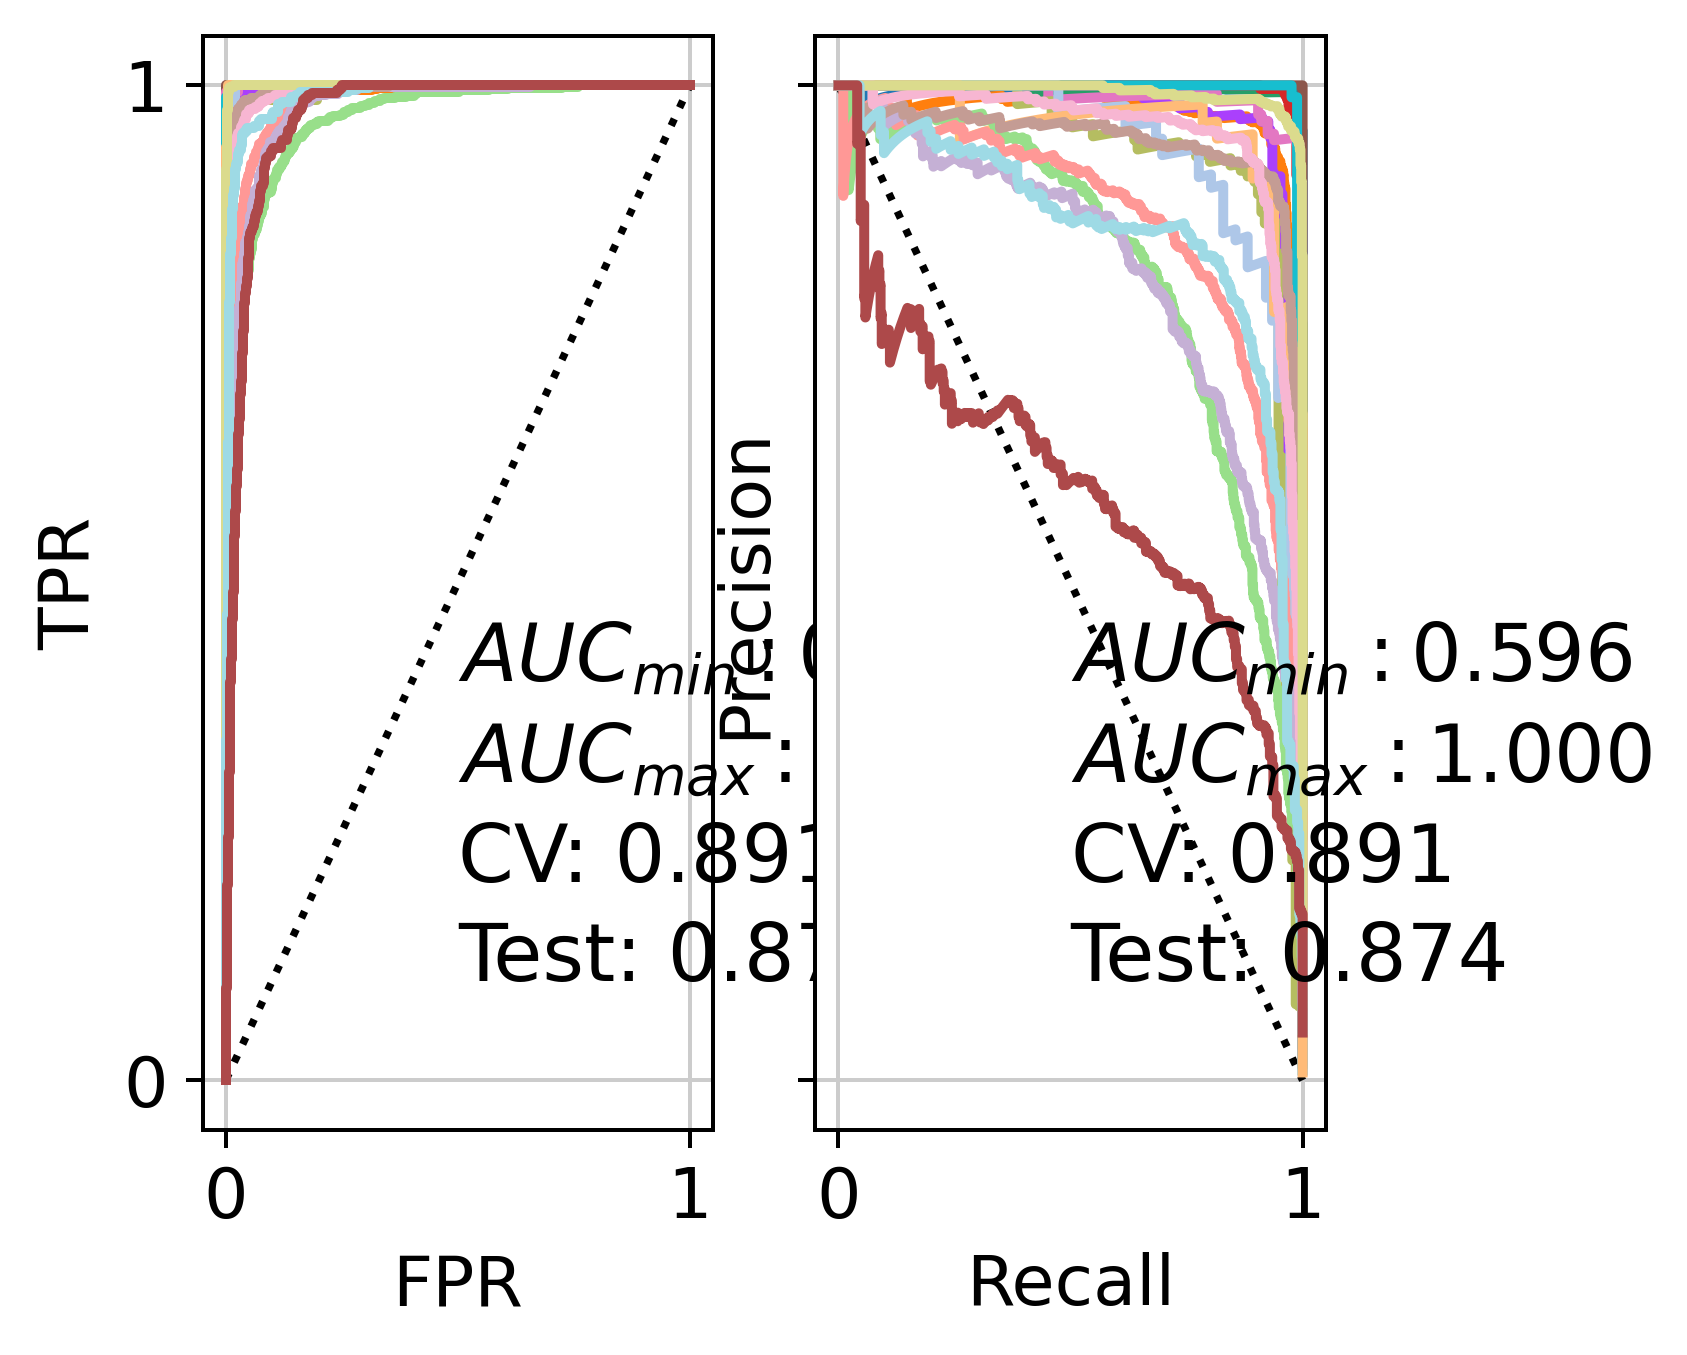

In [31]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.8, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.9 and assess with SCCAF

In [32]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
Mean CV accuracy: 0.9026
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8817


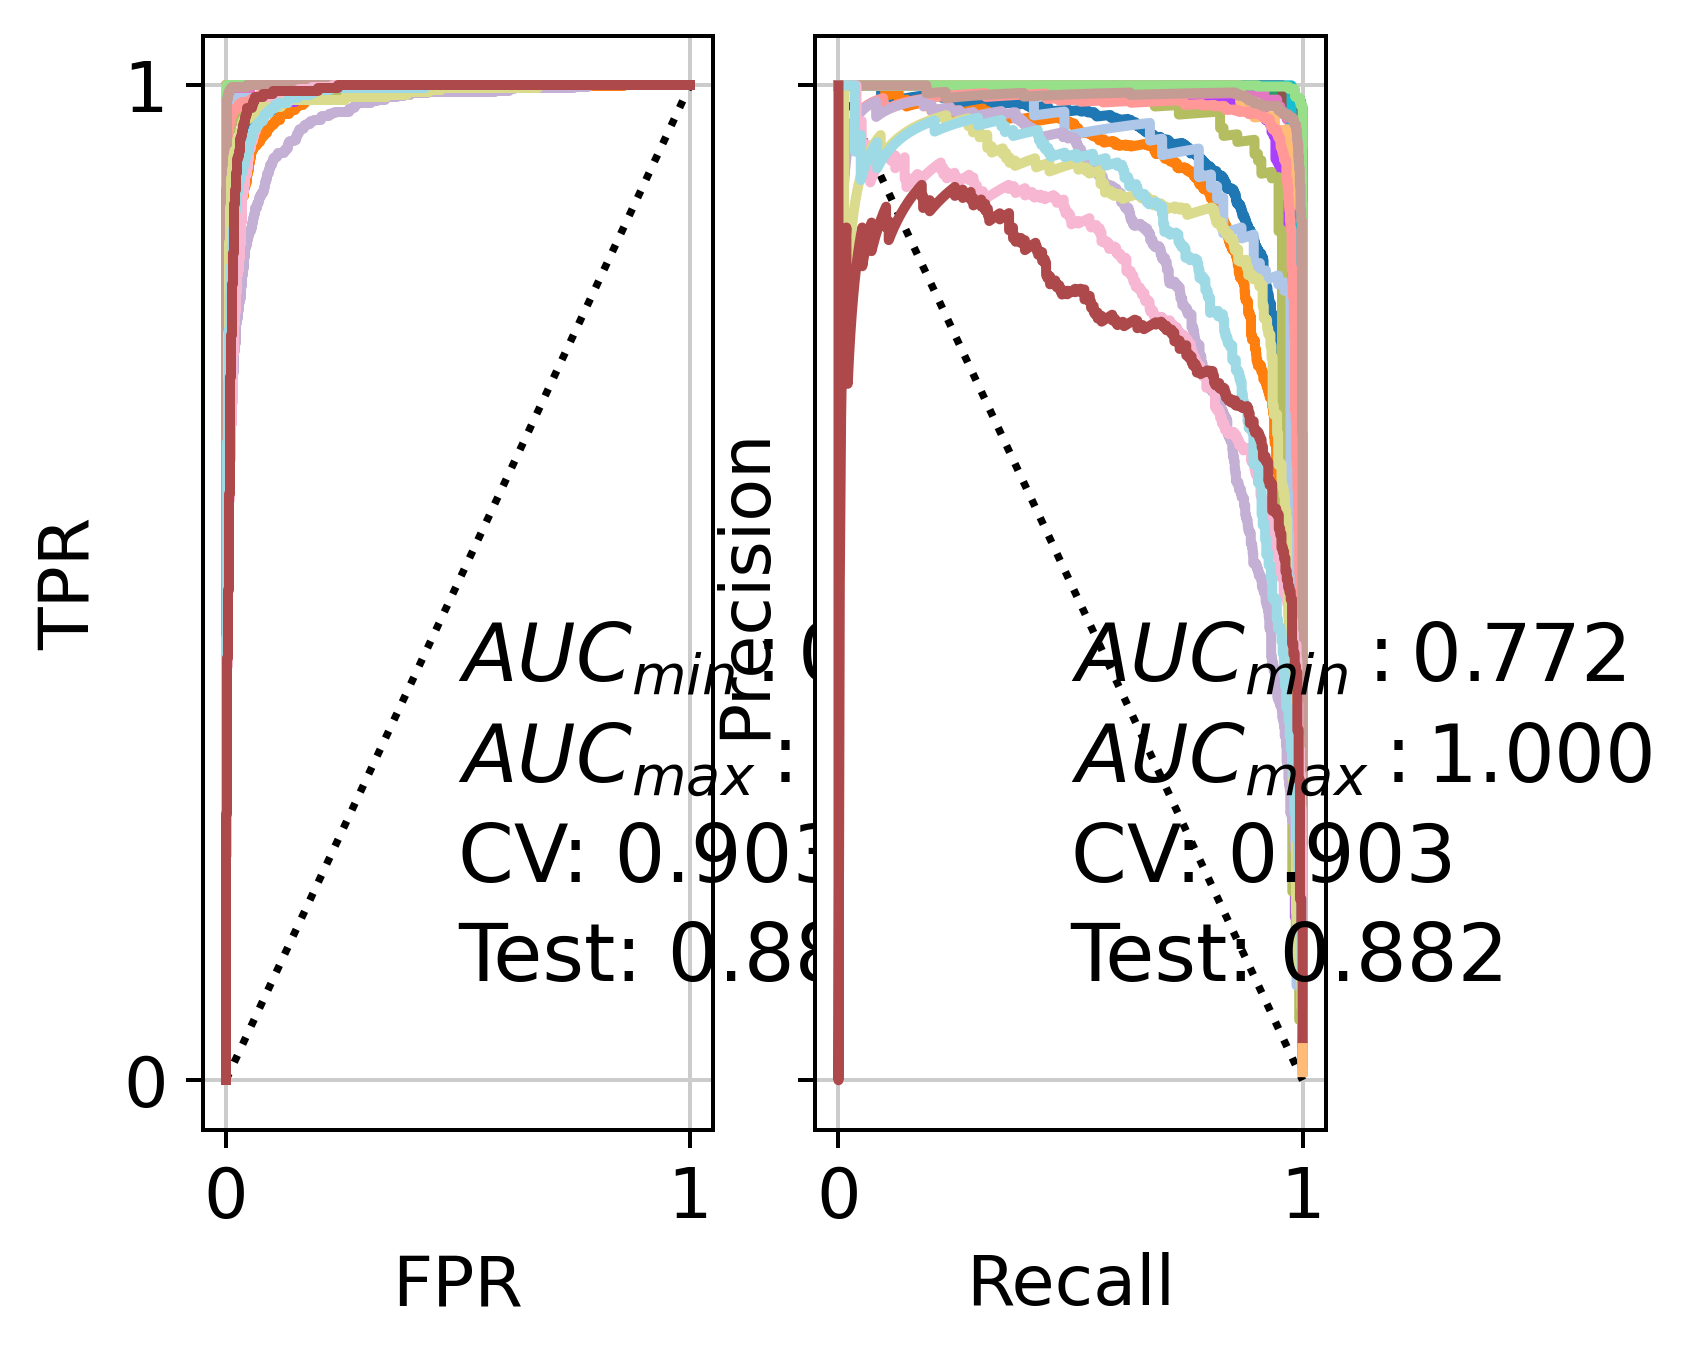

In [33]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.9, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 1.0 and assess with SCCAF

In [34]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)
Mean CV accuracy: 0.8701
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8416


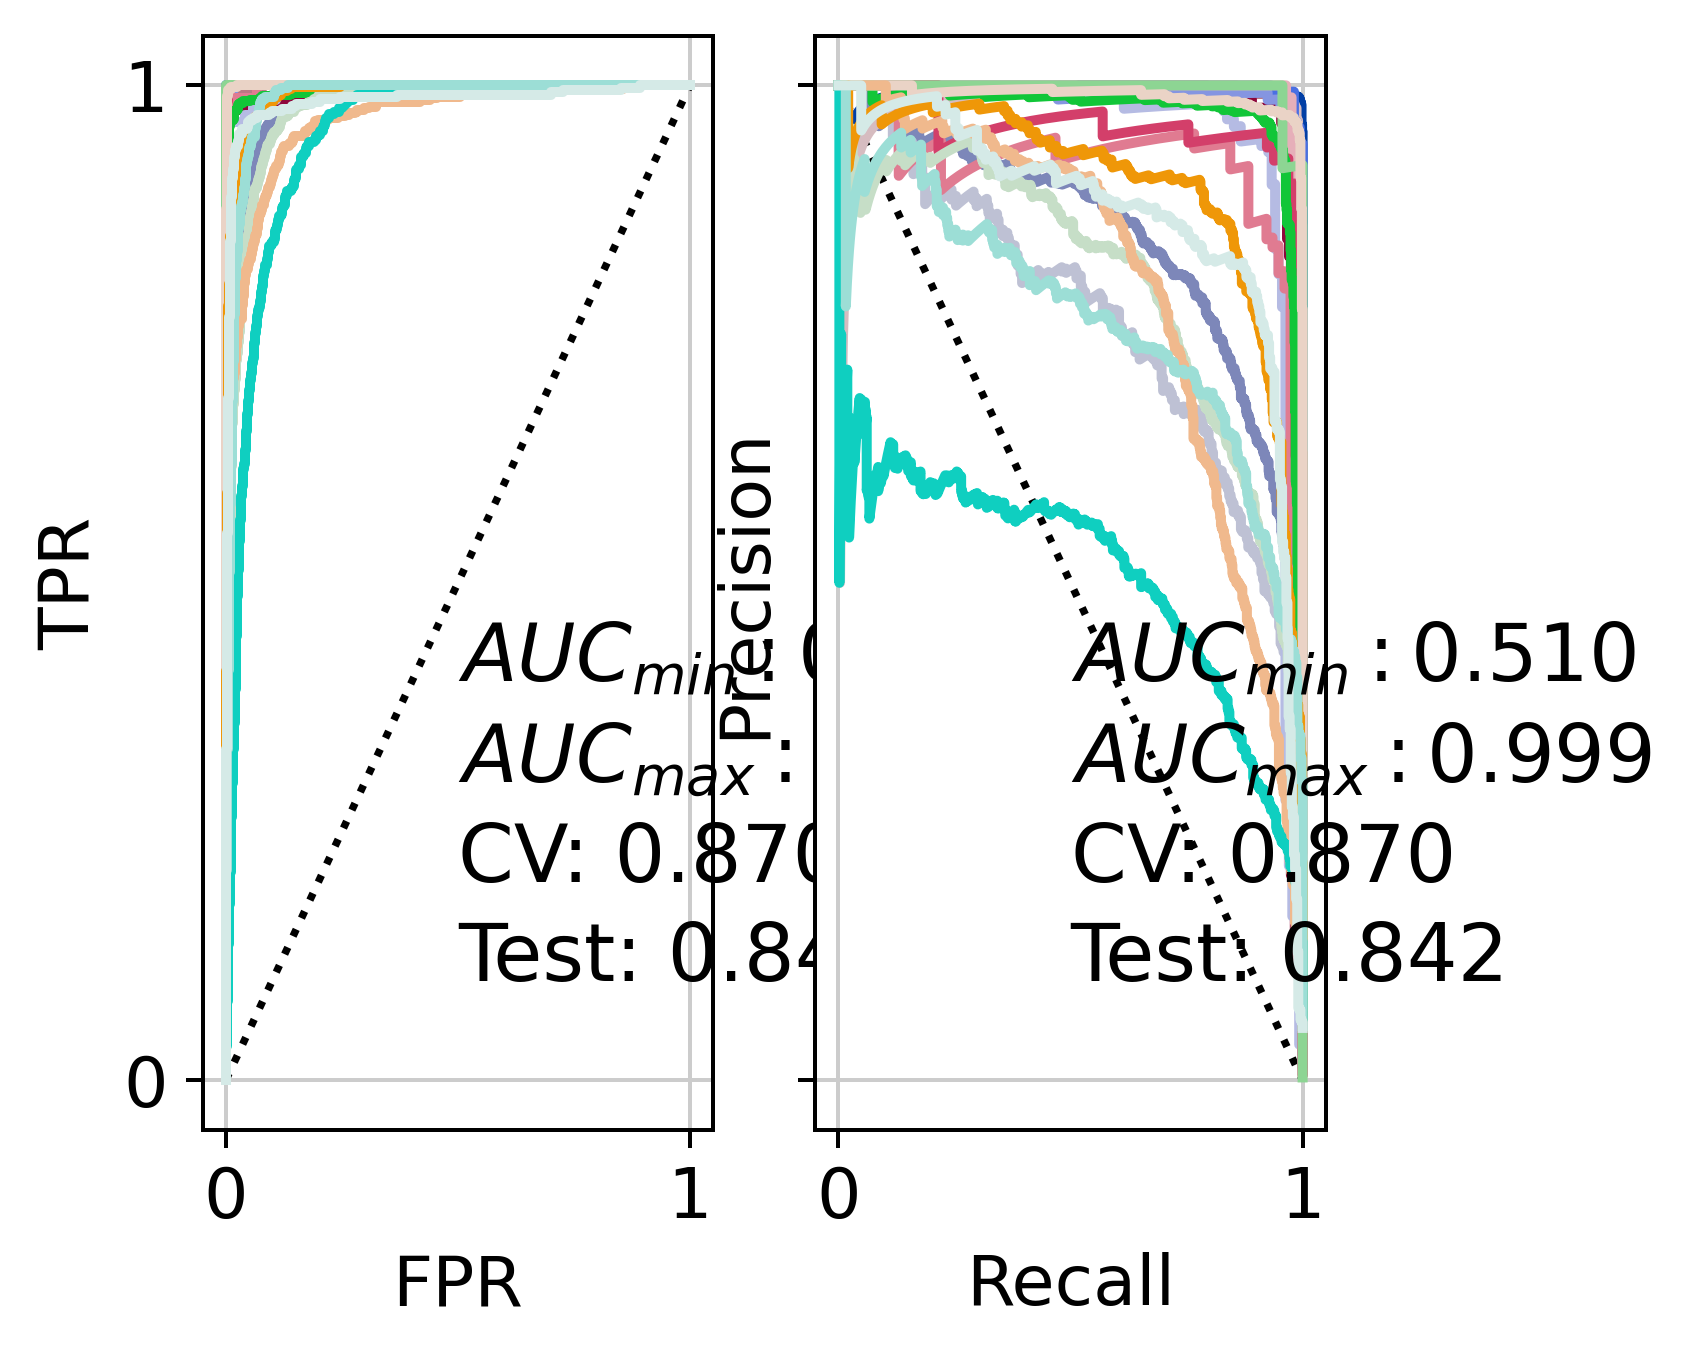

In [35]:
#Plotting code
sc.tl.leiden(adata, resolution = 1.0, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

### Choose Resolution for `leiden` clustering
Chosen: 0.7

In [56]:
sc.tl.leiden(adata, resolution = 0.7, random_state = 1786)

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


In [57]:
adata

AnnData object with n_obs × n_vars = 10104 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'
    uns: 'neighbors', 'C_scANVI_colors', 'log1p', 'leiden'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [58]:
sc.settings.set_figure_params(dpi = 300, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

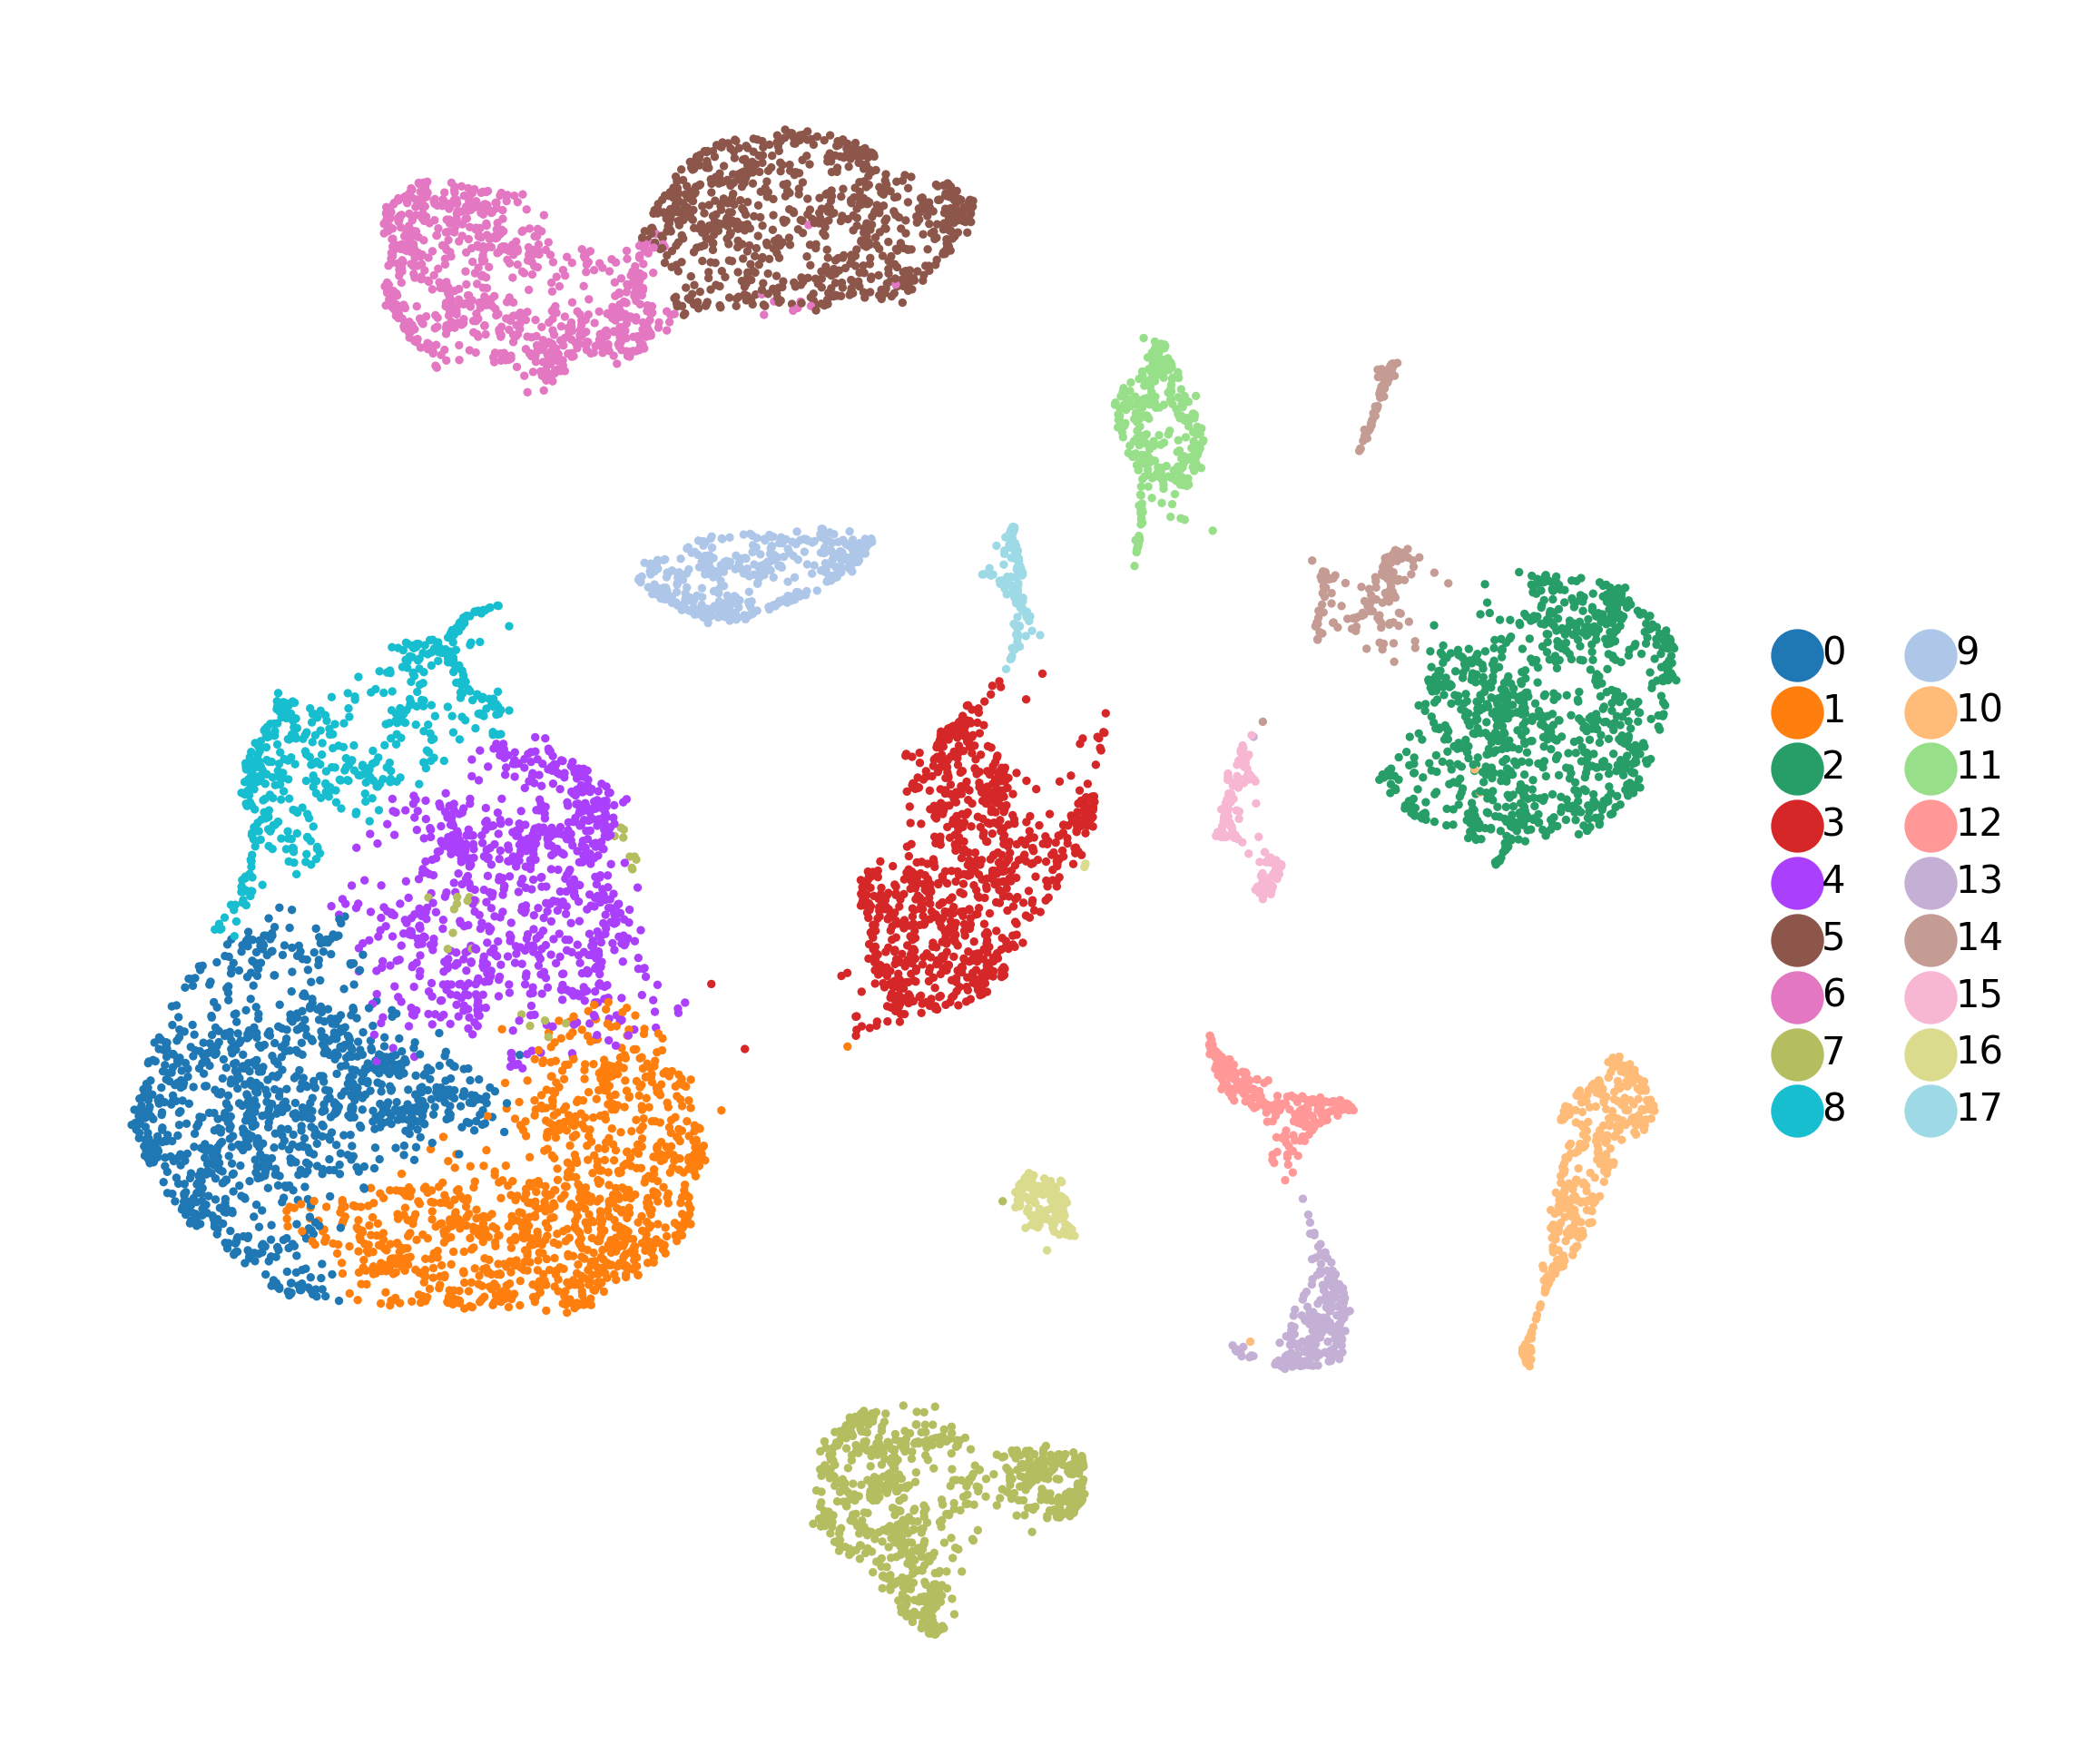

In [59]:
sc.pl.umap(adata, color=['leiden'], size = 5, frameon = False, legend_loc="right margin", legend_fontsize= 5, title='')

#### Restore the raw data

In [60]:
adata = anndata.AnnData(X = adata_raw.X, var = adata.var, obs = adata.obs, obsm = adata.obsm, obsp = adata.obsp, varm =adata.varm, uns = adata.uns)                    #make sure to store the raw X values and the raw genes together with modified observations
adata

AnnData object with n_obs × n_vars = 10104 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'
    uns: 'neighbors', 'C_scANVI_colors', 'log1p', 'leiden', 'leiden_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [61]:
X_data = adata.X.copy()
X_data_sparse = csr_matrix(X_data)
X_data_df = pd.DataFrame.sparse.from_spmatrix(X_data_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", X_data_df.shape)
print(X_data_df)

Shape of counts DataFrame: (10104, 29378)
                       Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  Gm37587  \
AAACCCAAGATACAGT-1-A1     0       0        0        0    0      0        0   
AACCCAATCAGCTGAT-1-A1     0       0        0        0    0      0        0   
AACCTGAAGATAGCAT-1-A1     0       0        0        0    0      0        0   
AACGTCAAGCTACTGT-1-A1     0       0        0        0    0      0        0   
AACTTCTCAAGCGCTC-1-A1     0       0        0        0    0      0        0   
...                     ...     ...      ...      ...  ...    ...      ...   
TTTGATCAGTATGACA-1-B2     0       0        0        0    0      0        0   
TTTGGAGAGATTAGCA-1-B2     0       0        0        0    0      0        0   
TTTGGTTAGCACCTGC-1-B2     0       0        0        0    0      0        0   
TTTGTTGAGACCTCCG-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTAGTAAGT-1-B2     0       0        0        0    0      0        0   

                     

### Update the mdata object

In [62]:
mdata.mod['rna'] = adata
mdata

MuData object with n_obs × n_vars = 10104 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	10104 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      uns:	'neighbors', 'C_scANVI_colors', 'log1p', 'leiden', 'leiden_colors'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
      obsp:	'distances', 'connectivities'
    prot:	10104 x 99
      obs:	'library', 'batch'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

In [63]:
rna_cells_export = set(mdata.mod['rna'].obs_names)
mask = mdata.mod['prot'].obs_names.isin(rna_cells_export)
filtered_prot_export = mdata.mod['prot'][mask]
mdata = mu.MuData({"rna": mdata.mod['rna'], "prot": filtered_prot_export})
mdata

MuData object with n_obs × n_vars = 10104 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	10104 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      uns:	'neighbors', 'C_scANVI_colors', 'log1p', 'leiden', 'leiden_colors'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
      obsp:	'distances', 'connectivities'
    prot:	10104 x 99
      obs:	'library', 'batch'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

Save results

In [64]:
#Save the results
mdata.write('/home/acirnu/data/ACM_cardiac_leuco/5_Leiden_clustering_and_annotation/ACM_lymphoids_leiden_clustering_muon_ac240415.raw.h5mu')